In [1]:
import warnings
warnings.simplefilter('ignore')

from sklearn import svm
import pickle
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import math
from scipy import sparse


from nltk.metrics.agreement import AnnotationTask

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV


from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.externals import joblib
from sklearn.preprocessing import FunctionTransformer

from stop_words import get_stop_words
pd.options.mode.chained_assignment = None
import string

import time
import re
import os
import json
import subprocess
import csv
import gzip
from datetime import datetime
import itertools

import matplotlib.pyplot as plt

# Tokenizers
from nltk.tokenize.casual import TweetTokenizer

# Imbalanced classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE, ADASYN

import sys
!{sys.executable} -m pip install --upgrade eli5
import eli5

sys.path.append('../../../../external_repositories/word2vec-twitter/')

from word2vecReader import Word2Vec

import krippendorff

Requirement already up-to-date: eli5 in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (0.10.1)
Requirement not upgraded as not directly required: tabulate>=0.7.7 in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (0.8.3)
Requirement not upgraded as not directly required: attrs>16.0.0 in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (18.2.0)
Requirement not upgraded as not directly required: six in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (1.11.0)
Requirement not upgraded as not directly required: scikit-learn>=0.18 in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (0.22.2.post1)
Requirement not upgraded as not directly required: jinja2 in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (2.10)
Requirement not upgraded as not directly required: graphviz in /Users/angelaschopke/miniconda3/lib/python3.6/site-packages (from eli5) (0.10.1)
Requiremen

# Set Notebook Parameters & Define Key Functions
Here we set variables necessary for pre-processing.

Krippendorff's alpha (inter-rater reliability) data fromat looks as follows (from module documentation - https://github.com/grrrr/krippendorff-alpha):

[
    {unit1:value, unit2:value, ...},  # coder 1
    {unit1:value, unit3:value, ...},   # coder 2
    ...                            # more coders
]

or 
it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) 
with rows corresponding to coders and columns to items

metric: function calculating the pairwise distance
force_vecmath: force vector math for custom metrics (numpy required)
convert_items: function for the type conversion of items (default: float)
missing_items: indicator for missing items (default: None)

In [2]:
## from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    ## This function prints and plots the confusion matrix.
    ## Normalization can be applied by setting `normalize=True`.

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py  
def show_conf_matrices(y_test, y_predictions):
    
    ## compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_predictions)
    np.set_printoptions(precision=2)

    ## make class labels
    y_labels = []
    for item in y_test:
        if item not in y_labels:
            y_labels.append(item)
        else:
            continue
    
    ## plot non-normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix,classes=y_labels,
                          title='Confusion matrix, without normalization')

    ## plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=y_labels, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

def eval_classifier(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)

    krippendorff_df = pd.DataFrame({'pred': y_pred, 'test': y_test})
    krippendorff_df['pred'] = krippendorff_df['pred'].astype('int')
    krippendorff_df['test'] = krippendorff_df['test'].astype('int')

    print(classification_report(y_test, y_pred) +  
      "\nCohen's kappa: " + str(cohen_kappa_score(y_test,y_pred)) + 
      "\nKrippendorff's alpha: " + str(krippendorff.alpha(krippendorff_df)))
    
    show_conf_matrices(y_test, y_pred)  

In [3]:
# tokenizer = RegexpTokenizer(r'\w+')
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True) # which tokenizer to use

stop_words_en = get_stop_words('en') # English stoplist
stop_words_sp = get_stop_words('spanish') # Spanish stoplist

stop_words_2 = []

for word in stop_words_en:
    stop_words_2.append(word)
for word in stop_words_sp:
    stop_words_2.append(word)


In [4]:
def tokenize_func(doc):

    ## remove URLs
    doc = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', doc, flags=re.MULTILINE)
    
    ## tokenize
    tokens = tokenizer.tokenize(doc)

    ## remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    nopunct_tokens = [w.translate(table) for w in tokens]
    for tok in nopunct_tokens:
        if 'httptco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])
        elif 'httpstco' in tok:
            ind = nopunct_tokens.index(tok)
            del(nopunct_tokens[ind])

    ## keep words length 3 or more
    long_tokens = [token for token in nopunct_tokens if len(token) > 2]

    ## remove remaining tokens that are not alphabetic
    alpha_tokens = [word for word in long_tokens if word.isalpha()]

    ## remove stop words from tokens
    stopped_tokens = [i for i in alpha_tokens if not i in stop_words_2]
        
    return stopped_tokens

def replace_urls(text):
    text_clean = re.sub(r'^(https|http)?:\/\/.*(\r|\n|\b)', '', text, flags=re.MULTILINE)
    return text_clean

# Get Data
Here we have the call for our datasets. Datasets necesssary for this process include:
    
    '../../../../data/russell/processed_hand_labeled_w2v_both.csv.gz'
    
produced by notebooks/models/create/feature_extraction/3.0-ams-w2v-featureextraction-pretrained, and

    '../../../../data/russell/processed_hand_labeled_w2v_both_liwc.csv.gz'

produced by running the preceding dataset through LIWC2015 software's csv analysis function. We do not include these intermediary datasets in our repository. As such, we comment out code that requires these datasets. However, in the event that you would like to run this commented-out code, these are reproducible using our notebooks/models/create/feature_extraction/ code and LIWC2015's software.

The final dataset resulting from the preprocessing steps which follow can be found at:

    '../../../../data/russell/russell_liwc_w2v_both.csv.gz'

In [201]:
## this function is necessary to reformat complete dataset (with both w2v and liwc features) with appropriate
## column names because liwc software renames non-liwc columns alphabetically.

def get_data(file_w2v, file_w2v_liwc):
    
    ## get dataset with no liwc features
    tweets = pd.read_csv(file_w2v, 
                         dtype=str, compression='gzip')
    tweets = tweets.drop(['Unnamed: 0'], axis=1)
    
    ## get dataset with liwc features
    liwc = pd.read_csv(file_w2v_liwc, 
                       compression='gzip', dtype=str)
    liwc = liwc.drop(['A'], axis=1)
    
    ## rename columns on dataset with liwc features
    tweets_header = list(tweets.columns.values)
    liwc_header = list(liwc.columns.values)[5:]
    new_header = tweets_header+liwc_header
    liwc.columns = new_header
        
    ## recast dataset with liwc features as full "tweets" df
    tweets = liwc
    
    ## preprocess text_no_urls field to make sure no na values remain
    tweets['text_no_urls'] = tweets['text_no_urls'].fillna(' ')
    
    return tweets   

In [180]:
def preprocess_w2v_features(df, original_w2v_column, pretrained_w2v_column):
    
    ## turn original w2v features column (now strings) into list
    df[original_w2v_column] = [df[:-1]+[df[-1][:-1]] 
                           for df in [df.split()[1:] 
                                         for df in list(df[original_w2v_column].values)]]

    ## turn original w2v features' vectors (now lists of strings) into lists of floats
    df[original_w2v_column] = [pd.to_numeric(vect) for vect in list(df[original_w2v_column].values)]
    
    ## turn pretrained w2v features column (now strings) into list
    df[pretrained_w2v_column] = [df[:-1]+[df[-1][:-1]] 
                           for df in [df.split()[1:] 
                                         for df in list(df[pretrained_w2v_column].values)]]

    ## turn pretrained w2v features' vectors (now lists of strings) into lists of floats
    df[pretrained_w2v_column] = [pd.to_numeric(vect) for vect in list(df[pretrained_w2v_column].values)]
    
    return df

In [204]:
def preprocess_liwc_features(df):
    
    ## define list of column names to be turned into numeric values
    # change back to 55 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    cols_to_numeric = list(tweets.columns.values)[5:]

    ## convert list of columns to numeric values
    for n in cols_to_numeric:
        df[n] = df[n].astype(float)
        
    return df

### Call Data Functions

In [ ]:
# tweets = get_data('../../../../data/russell/processed_hand_labeled_w2v_both.csv.gz',
#                  '../../../../data/russell/processed_hand_labeled_w2v_both_liwc.csv.gz')
# tweets = preprocess_w2v_features(tweets, 'w2v_features_original', 'w2v_features_pretrained')
# tweets = preprocess_liwc_features(tweets)

# Separate into Training and Test Sets

In [ ]:
## if not re-running the above data preprocessing code, load preprocessed dataset here
tweets = pd.read_csv( '../../../../data/russell/russell_liwc_w2v_both.csv.gz',
                    compression='gzip', dtype=str)

In [214]:
def make_combined_training_docs_all(df):
    
    col_names = list(tweets.columns.values)
    features = [col_names[1]]+col_names[3:]

    x_train, x_test, y_train, y_test = train_test_split(df[features],
                                                        df['new_topic_1'], test_size=0.10)
    
    return x_train, x_test, y_train, y_test


In [215]:
x_train_all, x_test_all, y_train_all, y_test_all = make_combined_training_docs_all(tweets)

# Vectorizers
Each of these classes is used to select and vectorize the appropriate features during model training

In [216]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec)

    def fit(self, X, y):
        return self

    def transform(self, X):
        means = np.array([sum(vector_vals)/len(vector_vals) if pd.isnull(vector_vals).all() == False 
                          else 0
                          for vector_vals in X])
        return means

In [217]:
class ArrayCaster(BaseEstimator, TransformerMixin):
    
    def fit(self, x, y=None):
        return self

    def transform(self, data):
        
        ## get mean of all values in vector to put in place of nan values
        col_mean = np.nanmean(data)
        col_means = np.full(data.shape, col_mean)
        
        ## find indicies that you need to replace
        inds = np.where(pd.isnull(data))
        
        ## place column means in the indices
        data[inds] = np.take(col_means, inds)
        
        return np.transpose(np.matrix(data))

In [218]:
class TextSelector(BaseEstimator, TransformerMixin):
   
    def __init__(self,key):
        self.key = key
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X[self.key] = X[self.key].fillna(' ')
        return X[self.key]

# Build Classifiers

## Logistic Regression Classifier

When attempting to run a logistic regression classifier on the child class (original) topic labeling system Dr. Russell used, receive the following error: "The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3." This could also be what is affecting the Naive Bayes performance and SVM. As such, the below logistic regression attempt attempts to predict only the PARENT class in Dr. Russell's data. This parent class was added as an additional column to Dr. Russell's data.

### Logistic Regression with LIWC Features

In [219]:
get_liwc_cols = FunctionTransformer(lambda x: x[list(tweets.columns.values)[5:]], validate=False)

In [ ]:
%%time
feature_pipeline = Pipeline([    
    
    ('feature-extraction', FeatureUnion([
        
            ('text-vector', Pipeline([
                ('select', TextSelector(key='text_no_urls')),
                ('countvec', CountVectorizer(tokenizer=tokenize_func)),
            ])),
            
            ('liwc-features', Pipeline([
                ('selector', get_liwc_cols),
                ('tfidf', TfidfTransformer(use_idf = False))
            ]))            
        ]

    )),
    
    ('lr', LogisticRegressionCV(multi_class='multinomial', solver='saga', max_iter=100))
])

feature_pipeline.fit(x_train_all, y_train_all)
## uncomment to save model
# joblib.dump(feature_pipeline, '../../../../models/best/lr/lr_multinomial_saga_liwc.pkl')
eval_classifier(feature_pipeline, x_test_all, y_test_all)

### Logistic Regression with Original OR Pretrained w2v Features

(37507,)
(37507, 1)
1208


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(4168,)
(4168, 1)
140
              precision    recall  f1-score   support

           0       0.51      0.64      0.57       225
           1       0.76      0.83      0.79       410
          10       0.81      0.62      0.71        96
          12       0.84      0.83      0.84       362
          13       0.66      0.68      0.67        57
          14       0.85      0.61      0.71        38
          15       0.68      0.67      0.68       163
          16       0.72      0.78      0.75       409
          17       0.77      0.60      0.68        45
          18       0.82      0.43      0.56        21
          19       0.77      0.79      0.78       224
           2       0.83      0.84      0.83       265
          20       0.75      0.77      0.76       349
          21       0.78      0.58      0.66        78
           3       0.93      0.91      0.92       583
           4       0.88      0.81      0.85       112
           5       0.60      0.58      0.59       117
     

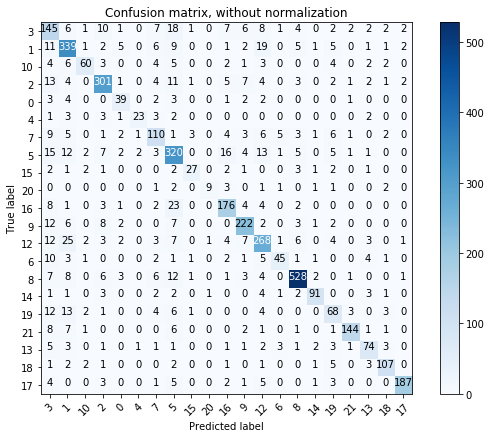

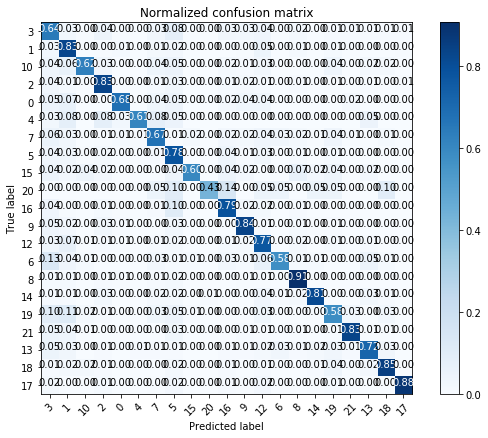

CPU times: user 2min 52s, sys: 1.79 s, total: 2min 53s
Wall time: 2min 51s


In [34]:
%%time
feature_pipeline = Pipeline([    
    
    ('feature-extraction', FeatureUnion([
        
            ('text-vector', Pipeline([
                ('select', TextSelector(key='text_no_urls')),
                ('countvec', CountVectorizer(tokenizer=tokenize_func)),
            ])),
            
            ('w2v-features', Pipeline([
                ('select', TextSelector(key='w2v_features_original')),
                ('meanw2v', MeanEmbeddingVectorizer('w2v_features_original')),
                ('caster', ArrayCaster())
            ]))
            
        ]

    )),
    
    ('lr', LogisticRegressionCV(multi_class='multinomial', solver='saga', max_iter=100))
])

feature_pipeline.fit(x_train_all, y_train_all)
## uncomment to save model
# joblib.dump(feat_pipe, '../../../../models/best/lr/lr_multinomial_saga_originalw2v.pkl')
eval_classifier(feature_pipeline, x_test_all, y_test_all)

In [ ]:
%%time
feature_pipeline = Pipeline([    
    
    ('feature-extraction', FeatureUnion([
        
            ('text-vector', Pipeline([
                ('select', TextSelector(key='text_no_urls')),
                ('countvec', CountVectorizer(tokenizer=tokenize_func)),
            ])),
            
            ('w2v-features', Pipeline([
                ('select', TextSelector(key='w2v_features_pretrained')),
                ('meanw2v', MeanEmbeddingVectorizer('w2v_features_pretrained')),
                ('caster', ArrayCaster())
            ]))
            
        ]

    )),
    
    ('lr', LogisticRegressionCV(multi_class='multinomial', solver='saga', max_iter=100))
])

feature_pipeline.fit(x_train_all, y_train_all)
## uncomment to save model
# joblib.dump(feat_pipe, '../../../../models/best/lr/lr_multinomial_saga_pretrainedw2v.pkl')
eval_classifier(feature_pipeline, x_test_all, y_test_all)

In [21]:
eli5.show_weights(lr, top=20, vec=vec)

## SVM Classifier

### Identify Optimal SVM C and Gamma Parameters (GridSearch)
Note that this process can take several hours.

In [20]:
# %%time
# param_grid = {'svc__C': [1, 5, 10, 50],
#               'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# grid = GridSearchCV(pipeline, param_grid)

# grid.fit(x_train_all, y_train_all)
# print(grid.best_params_)

/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'svc__C': 50, 'svc__gamma': 0.005}
CPU times: user 3h 4min 11s, sys: 49.1 ms, total: 3h 4min 11s
Wall time: 3h 4min 11s


### SVM with w2v or LIWC Features
The prepopulated kernel (best performing) is 'rbf' here. We also tried 'linear' and 'poly' kernels.

              precision    recall  f1-score   support

           0       0.42      0.63      0.51       187
           1       0.76      0.79      0.78       430
          10       0.72      0.74      0.73        74
          12       0.81      0.86      0.83       360
          13       0.74      0.60      0.66        57
          14       0.83      0.65      0.73        37
          15       0.73      0.67      0.70       190
          16       0.71      0.74      0.72       367
          17       0.71      0.61      0.66        49
          18       0.50      0.38      0.43        13
          19       0.77      0.74      0.75       215
           2       0.85      0.78      0.81       256
          20       0.72      0.75      0.74       343
          21       0.76      0.58      0.66        76
           3       0.90      0.90      0.90       599
           4       0.87      0.79      0.83       114
           5       0.58      0.55      0.57       121
           6       0.87    

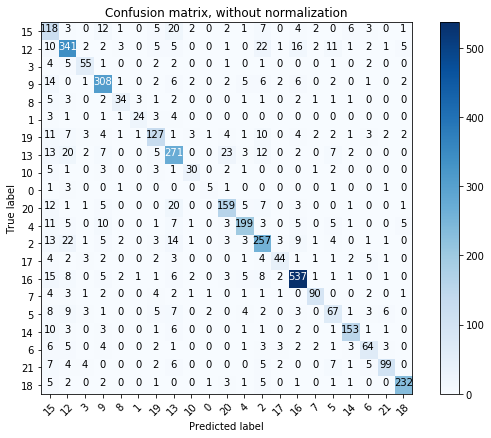

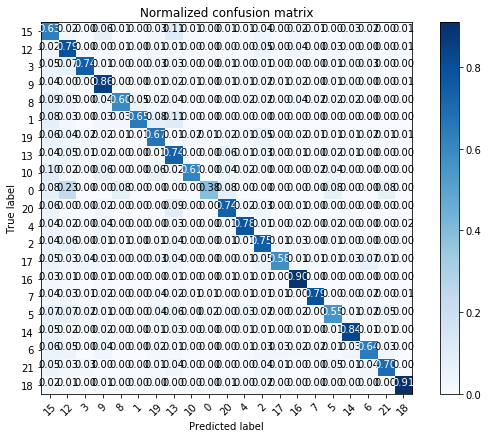

CPU times: user 6min 50s, sys: 1.5 s, total: 6min 51s
Wall time: 6min 50s


In [136]:
%%time
## uncomment features from featureunion as needed to evaluate each feature individually
## or in combination with others

feature_pipeline = Pipeline([    
    
    ('feature-extraction', FeatureUnion([           
        
            ('text-vector', Pipeline([
                ('select', TextSelector(key='text_no_urls')),
                ('countvec', CountVectorizer(tokenizer=tokenize_func)),
            ])),
        
            ('liwc-features', Pipeline([
                ('select', get_liwc_cols),
                ('tfidf', TfidfTransformer(use_idf = False)),
            ]))
            
#             ('w2v-features-original', Pipeline([
#                 ('select', TextSelector(key='w2v_features_original')),
#                 ('meanw2v', MeanEmbeddingVectorizer('w2v_features_original')),
#                 ('caster', ArrayCaster())
#             ])),
        
#             ('w2v-features-pretrained', Pipeline([
#                 ('select', TextSelector(key='w2v_features_pretrained')),
#                 ('meanw2v', MeanEmbeddingVectorizer('w2v_features_pretrained')),
#                 ('caster', ArrayCaster())
#             ]))
            
        ]

    )),
    
    ('svm', SVC(kernel='rbf', gamma=0.005, C=50))
])


feature_pipeline.fit(x_train_all, y_train_all)
## uncomment to save model(s)
# joblib.dump(feature_pipeline, '../../../../models/best/svm/svm_rbf_gridoptimized.pkl')
# joblib.dump(feature_pipeline, '../../../../models/best/svm/svm_rbf_gridoptimized_liwc.pkl')
# joblib.dump(feature_pipeline, '../../../../models/best/svm/svm_rbf_gridoptimized_originalw2v.pkl')
# joblib.dump(feature_pipeline, '../../../../models/best/svm/svm_rbf_gridoptimized_pretrainedw2v.pkl')
# joblib.dump(feature_pipeline, '../../../../models/best/svm/svm_rbf_gridoptimized_liwc_pretrainedw2v.pkl')
eval_classifier(feature_pipeline, x_test_all, y_test_all)